<a href="https://colab.research.google.com/github/farbowitz/A2_KT_data/blob/main/P3HT_PCBM_TA_analysis_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.stats import linregress
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.signal import argrelmax
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/P3HT-PCBM TA Group import"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/P3HT-PCBM TA Group import/","")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)

  #Some cleaning
  df = df.rename({'0.00000E+0.1':'0.000000000'}, axis=1)
  cols = df.columns.values
  cols[0] = 'Wavelength(nm)'
  df.columns = cols
  #remove extraneous data at the end
  df = df[pd.to_numeric(df['Wavelength(nm)'], errors='coerce').notnull()]
  df['Wavelength(nm)'] = df['Wavelength(nm)'].astype(float)
  df = df.set_index('Wavelength(nm)')
  #remove rows (wavelengths) with at least 3 na values
  df = df.dropna(axis=0, thresh=3)
  df = df.dropna(axis=1, thresh=3)

  #change strings to numbers
  df = df.astype(float)
  df.columns = pd.to_numeric(df.columns)

  titles.append(new_name)
  Spec_data[new_name] = df

Spec_data



Mounted at drive


{'P3HT neat film .7mW ChlBnz 20min run1 UV-Vis (corrected)':                 -4.93249     -4.43249     ...   6623.22000   6999.82000
 Wavelength(nm)                            ...                          
 335.695                 NaN    -0.000047  ...    -0.000207     0.000030
 336.268                 NaN     0.000139  ...    -0.000088    -0.000219
 336.841                 NaN     0.000127  ...    -0.000004    -0.000005
 337.413                 NaN     0.000151  ...     0.000328    -0.000246
 337.986                 NaN     0.000041  ...     0.000301    -0.000259
 ...                     ...          ...  ...          ...          ...
 825.485           -0.000305     0.000135  ...     0.001131     0.001159
 826.090            0.000897     0.000430  ...     0.001883     0.000331
 826.695           -0.000002    -0.000024  ...    -0.000385     0.000748
 827.300            0.000568    -0.000566  ...    -0.000861     0.000107
 827.905            0.000614     0.001061  ...     0.000560     

In [ ]:
folder = "/content/drive/MyDrive/Data from Lit"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Lit_data = {}



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/Data from Lit/","")
  #import data
  df = pd.read_csv(filename, sep=',', header=None)
  df.columns = ['Wavelength(nm)','ΔA']
  #remove extraneous data at the end
  df = df[pd.to_numeric(df['Wavelength(nm)'], errors='coerce').notnull()]
  df['Wavelength(nm)'] = df['Wavelength(nm)'].astype(float)
  df = df.set_index('Wavelength(nm)')
  df = df.sort_index()
  print(new_name)
  print(df)
  Lit_data[new_name] = df

0000 Guo2011 rr-P3HT neat TA 0ps
                      ΔA
Wavelength(nm)          
483.477241     -0.024103
490.176538     -0.026041
495.743891     -0.028754
505.802797     -0.030951
510.250884     -0.033535
516.942936     -0.035991
523.465334     -0.034372
531.562218     -0.032759
540.552570     -0.031207
548.371133     -0.033274
562.830962     -0.036143
562.934270     -0.034049
567.456613     -0.031335
568.617534     -0.028491
570.906778     -0.025131
576.580986     -0.020219
579.993118     -0.016730
587.869636     -0.014661
596.789354     -0.018150
598.978987     -0.021898
602.313241     -0.023966
614.626979     -0.025257
618.035489     -0.022026
622.776755     -0.019029
627.989033     -0.012277
631.459690     -0.008075
631.725671     -0.005095
634.052948      0.000980
636.371169      0.006408
648.746485      0.009511
670.057820      0.010288
681.246859      0.008737
697.609325      0.005394
731.621080      0.003442
757.864685      0.004020
797.291814      0.004180
832.581421      0

In [ ]:
#routine for switching between type comparisons
def switch(name):
  if ('NPs' in name) and ('film' in name):
    return 'Blend Nanoparticles in Annealed Film'
  elif ('sol' in name) and ('NPs' in name):
    return 'Blend Nanoparticles in Solution'
  elif ('bhj' in name) and ('film' in name):
    k = name.split(sep=' ')[0]
    return k + ' in Bulk Annealed Film'
  else:
    return ' '

f=10000
#for excitations, hc needs to be in uJ*nm
hc = 1.98644586*(10**(-10))
pump_wl = 400
###Note to self: ADD IN OD data###
sol_nps_OD = 0.1526
NP_film_OD = 0.1534
P3HT_OD = 0.25
OD = 0.4
#square beam area due to coordinates
beam_area = (0.025**2)
#proportion of beam in central probe region
beam_prop = 0.8183

def fluence_translate(name, OD=0.4):
  #note units are uJ/cm^2
  P = 0
  words = name.split()
  for word in words:
    if ('uW' in word):
      P = float(word.replace('uW', ''))
    if ('mW' in word):
      P = 1000*float(word.replace('mW',''))
  if ('P3HT' in name) and (not ('PCBM' in name)):
    OD = P3HT_OD
  elif ('sol' in name):
    OD = sol_nps_OD
  elif ('film' in name) and ('NP' in name):
    OD = NP_film_OD
  photon_E = hc/pump_wl
  photons_absorbed = 1 - (10**(-OD))
  #Excitation Density
  #return photons_absorbed*P*0.8/(f*photon_E*beam_area)
  #E per pulse per area
  return P*beam_prop/(f*beam_area)

for name in Spec_data:
  print(name)
  print(str(fluence_translate(name)))

P3HT-PCBM NPs sol 24uW 2mm UV-Vis (corrected)
3.1422719999999997
P3HT-PCBM NPs sol 100uW 2mm UV-Vis (corrected)
13.092799999999999
P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)
60.357808
P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)
128.30944
P3HT-PCBM NPs sol 9800uW 2mm NIR (corrected)
1283.0944
P3HT-PCBM NPs film 20uW UV-Vis (corrected)
2.6185599999999996
P3HT-PCBM NPs film 100uW UV-Vis (corrected)
13.092799999999999
P3HT-PCBM NPs film 500uW UV-Vis (corrected)
65.464
P3HT-PCBM NPs film 980uW NIR (corrected)
128.30944
P3HT-PCBM NPs film 9700uW NIR (corrected)
1270.0015999999998
P3HT-PCBM NPs agg film 980uW NIR (corrected)
128.30944
P3HT-PCBM NPs agg film 9800uW NIR (corrected)
1283.0944
P3HT-PCBM film bhj 200uW min run1 UV-Vis (corrected)
26.185599999999997
P3HT neat film .7mW ChlBnz 20min run1 UV-Vis (corrected)
91.64959999999999
P3HT-PCBM bhj film 700uW min run2 UV-Vis (corrected)
91.64959999999999


Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

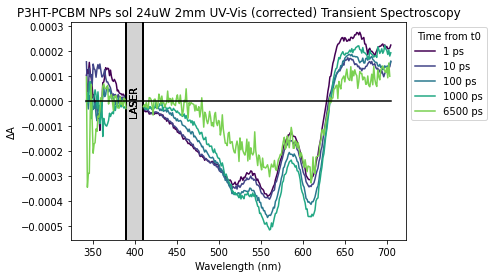

P3HT-PCBM NPs sol 24uW 2mm UV-Vis (corrected)


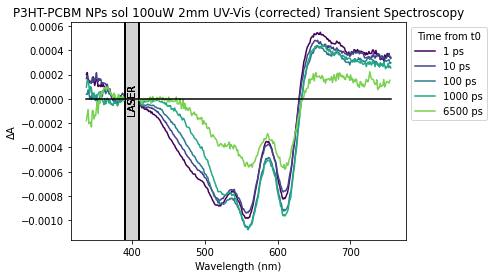

P3HT-PCBM NPs sol 100uW 2mm UV-Vis (corrected)


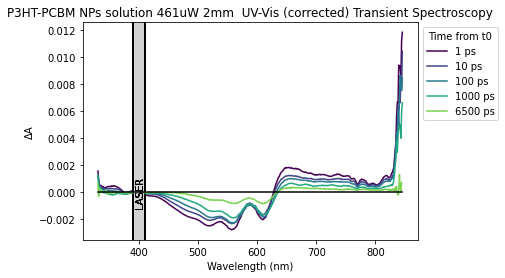

P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)


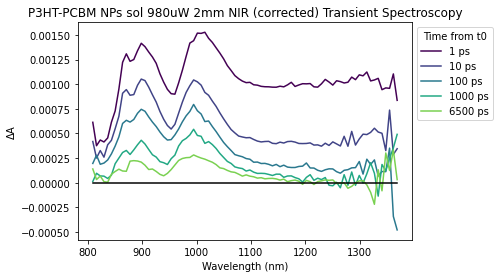

P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)


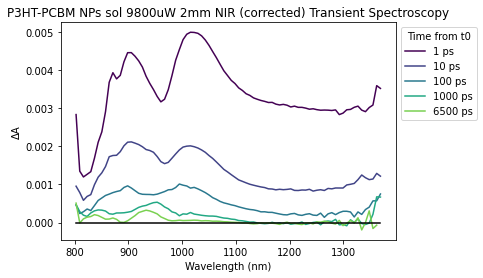

P3HT-PCBM NPs sol 9800uW 2mm NIR (corrected)


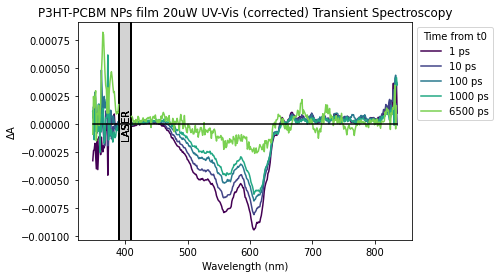

P3HT-PCBM NPs film 20uW UV-Vis (corrected)


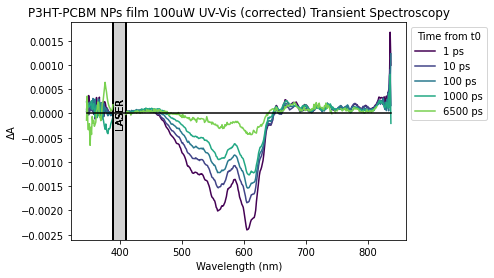

P3HT-PCBM NPs film 100uW UV-Vis (corrected)


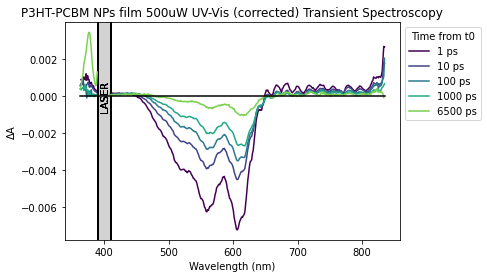

P3HT-PCBM NPs film 500uW UV-Vis (corrected)


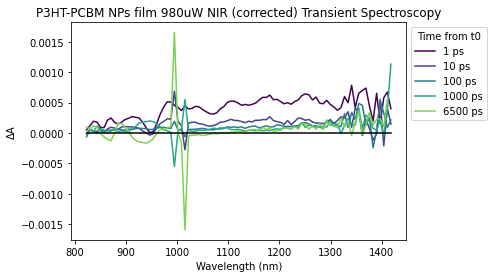

P3HT-PCBM NPs film 980uW NIR (corrected)


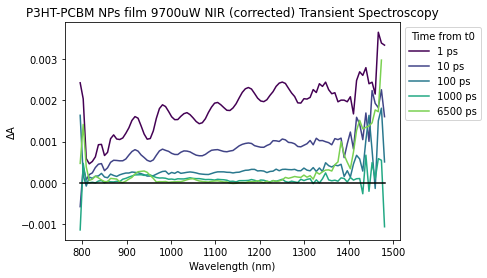

P3HT-PCBM NPs film 9700uW NIR (corrected)


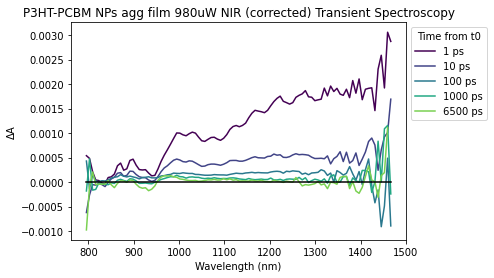

P3HT-PCBM NPs agg film 980uW NIR (corrected)


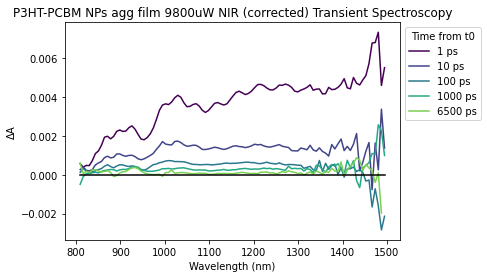

P3HT-PCBM NPs agg film 9800uW NIR (corrected)


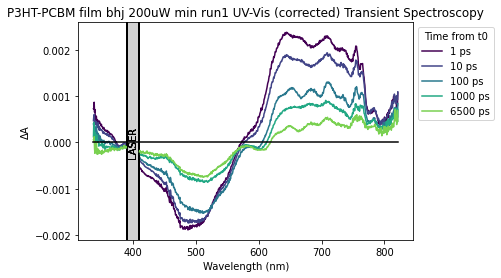

P3HT-PCBM film bhj 200uW min run1 UV-Vis (corrected)


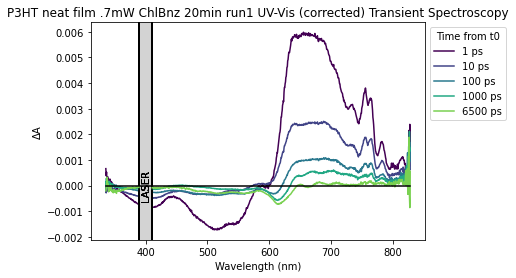

P3HT neat film .7mW ChlBnz 20min run1 UV-Vis (corrected)


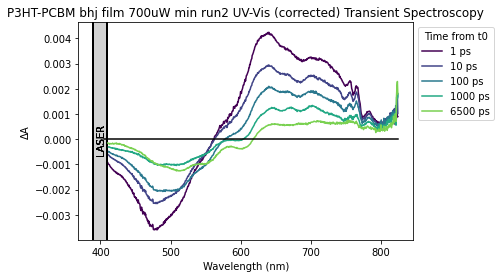

P3HT-PCBM bhj film 700uW min run2 UV-Vis (corrected)


In [ ]:
def spec_time_data(data, name, times):
  for i in range(len(times)):
      x = np.asarray(data[name].index)
      y = np.asarray(data[name][times[i]])
      if 'UV-Vis' in name:
        y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
        plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
        plt.axvline(pump_wl-10, color='black')
        plt.axvline(pump_wl+10, color='black')
        plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
      plt.plot(x, y,  label=str(dex[i])+' ps', color=colormap(i/len(times)))
      plt.legend(title='Time from t0', bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength (nm)')
      plt.ylabel('ΔA')
#color method from stack exchange :https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
#def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
#    c1=np.array(mpl.colors.to_rgb(c1))
#    c2=np.array(mpl.colors.to_rgb(c2))
#    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#c1='white' 
#c2='black' 
#better color method
colormap = cm.get_cmap('viridis')
#find global maxes to fix TA scale

bmaxes=[]
bmins=[]

for name in Spec_data:
  bmaxes.append(Spec_data[name].max().max())
  bmins.append(Spec_data[name].min().min())

bmax = max(bmaxes)
bmin = min(bmins)

#https://codereview.stackexchange.com/questions/189319/nearest-neighbor-algorithm-general-neares
def find_nearest(array, number, direction): 
    idx = -1
    if direction is None:
        idx = (np.abs(array - number)).min()
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta_positive.min()
    return idx

#filling 'times' list with closest values found in time stamps (columns)
for name in Spec_data:
  dex = [1, 10, 100, 1000, 6500]
  times = []
  for i in range(len(dex)):
    times.append(find_nearest(Spec_data[name].columns,dex[i], 'forward')+dex[i])
  spec_time_data(Spec_data, name, times)
  plt.plot(np.array(Spec_data[name].index), np.zeros(len(Spec_data[name].index), dtype=float, order='C'), color='black')
  plt.show()


  print(name)
  plt.show()




Try adding again?

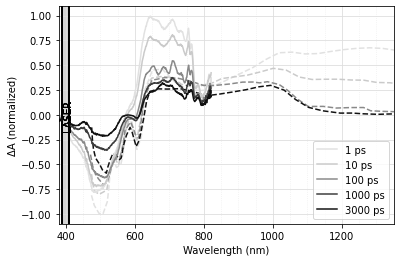

In [ ]:
###Okay, don't worry about the other stuff right now, just print your data out

#BHJ TA

viridis = cm.get_cmap('Greys')
norm=1
t=0
for name in sorted(Lit_data):

  if ('Guo' in name) and ('P3HT-PCBM' in name):
    data = Lit_data[name]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    if int(t) == 1:
      norm = abs(y).max()
    plt.plot(x, y/norm, linestyle='--',color=viridis(np.log(int(t)+5)/np.log(5005)))




df = Spec_data['P3HT-PCBM film bhj 200uW min run1 UV-Vis (corrected)']
norm = abs(df[find_nearest(df.columns, 1, 'forward')+1]).max()
t0 = abs(df).max().idxmax(axis=1)

d1 = [1,10, 100, 1000, 3000]
dex = d1
times = []


for i in range(len(dex)):
  times.append(find_nearest(df.columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]].rolling(3).mean())/norm
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(d1[i]))+' ps', color=viridis(np.log(int(d1[i])+5)/np.log(5005)))
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')
plt.xlim(380, 1350)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
plt.tick_params(which='minor', bottom=False, left=False)

plt.legend()
plt.show()


0 0.0361426876680149


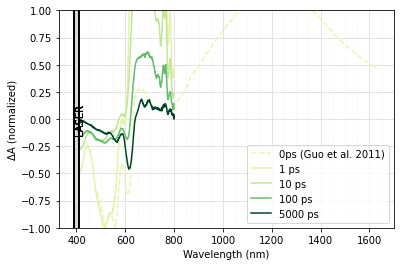

In [ ]:
#JUST P3HT

viridis = cm.get_cmap('YlGn')
norm=1
t=0
for name in sorted(Lit_data):

  if ('Guo' in name) and ('neat' in name):
    data = Lit_data[name]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    if int(t) == 0:
      norm = abs(y[x<800]).max()
    print(t, norm)
    plt.plot(x, y/norm, label=t + 'ps (Guo et al. 2011)', linestyle='--',color=viridis(np.log(int(t)+5)/np.log(5005)))




df = Spec_data['P3HT neat film .7mW ChlBnz 20min run1 UV-Vis (corrected)']
df = df[df.index<800]
df = df[df.index>405]
norm = abs(df[find_nearest(df.columns, 1, 'forward')+1][df.index<550]).max()
t0 = abs(df).max().idxmax(axis=1)

d1 = [1,10, 100, 5000]
dex = d1
times = []


for i in range(len(dex)):
  times.append(find_nearest(df.columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]].rolling(3).mean())/norm
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(d1[i]))+' ps', color=viridis(np.log(int(d1[i])+5)/np.log(5005)))

plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
plt.tick_params(which='minor', bottom=False, left=False)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')

plt.ylim(-1,1)
plt.legend()
plt.show()

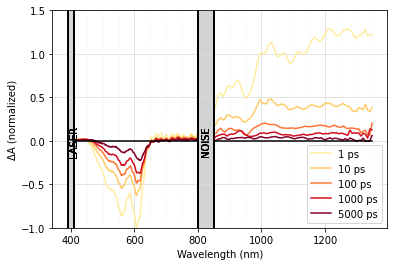

In [ ]:
#NP film TA
viridis = cm.get_cmap('YlOrRd')
df = Spec_data['P3HT-PCBM NPs film 500uW UV-Vis (corrected)']
df = df[df.index<800]
df = df[df.index>405]
norm = abs(df[find_nearest(df.columns, 1, 'forward')+1]).max()
t0 = abs(df).max().idxmax(axis=1)

d1 = [1,10, 100, 1000, 5000]
dex = d1 
times = []


for i in range(len(dex)):
  times.append(find_nearest(df.columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]])/norm
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(d1[i]))+' ps', color=viridis(np.log(int(d1[i])+2)/np.log(5002)))
times=[]

df_NIR = Spec_data['P3HT-PCBM NPs agg film 9800uW NIR (corrected)']
df_NIR = df_NIR[df_NIR.index > 850]
df_NIR = df_NIR[df_NIR.index < 1350]
for i in range(len(dex)):
  times.append(find_nearest(df_NIR.columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df_NIR.index)
  y = np.asarray(df_NIR[times[i]])/(0.5*norm)

  plt.axvspan(800, 850, color='lightgray')
  plt.axvline(800, color='black')
  plt.axvline(850, color='black')
  plt.text(810,0, 'NOISE',rotation='vertical', va='center')
  plt.plot(x, y, color=viridis(np.log(int(d1[i])+2)/np.log(5002)))

plt.plot(np.array(df.index), np.zeros(len(df.index), dtype=float, order='C'), color='black')
plt.plot(np.array(df_NIR.index), np.zeros(len(df_NIR.index), dtype=float, order='C'), color='black')

plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
plt.tick_params(which='minor', bottom=False, left=False)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')

plt.ylim(-1, 1.5)
plt.legend()
plt.show()

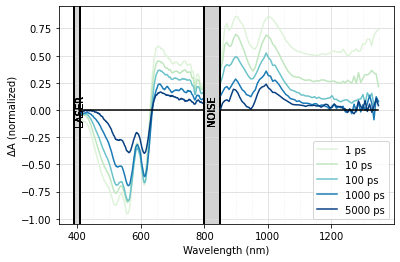

In [ ]:
## MY NP SOLUTION
viridis = cm.get_cmap('GnBu')

df = Spec_data['P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)']
df = df[df.index<800]
df=df[df.index>405]
norm = abs(df[find_nearest(df.columns, 1, 'forward')+1].rolling(10).mean()).max()
t0 = abs(df).max().idxmax(axis=1)

d1 = [1,10, 100, 1000, 5000]
dex = d1+t0 
times = []


for i in range(len(dex)):
  times.append(find_nearest(df.columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]].rolling(3).mean())/norm
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(d1[i]))+' ps', color=viridis(np.log(int(d1[i])+2)/np.log(5002)))
times=[]
for i in range(len(dex)):
  times.append(find_nearest(Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)'].columns,dex[i], 'forward')+dex[i])
df_NIR = Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)']
df_NIR = df_NIR[df_NIR.index > 850]
df_NIR = df_NIR[df_NIR.index < 1350]

for i in range(len(times)):
  x = np.asarray(df_NIR.index)
  y = np.asarray(df_NIR[times[i]])*1.8/norm

  plt.axvspan(800, 850, color='lightgray')
  plt.axvline(800, color='black')
  plt.axvline(850, color='black')
  plt.text(810,0, 'NOISE',rotation='vertical', va='center')
  plt.plot(x, y, color=viridis(np.log(int(d1[i])+2)/np.log(5002)))

plt.plot(np.array(df.index), np.zeros(len(df.index), dtype=float, order='C'), color='black')
plt.plot(np.array(df_NIR.index), np.zeros(len(df_NIR.index), dtype=float, order='C'), color='black')

plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
plt.tick_params(which='minor', bottom=False, left=False)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')

plt.legend()
plt.show()

In [ ]:
print(fluence_translate('P3HT-PCBM NP film 500uW  UV-Vis (corrected)'))
fluence_translate('P3HT-PCBM NP film 980uW NIR (corrected)')

65.464


128.30944

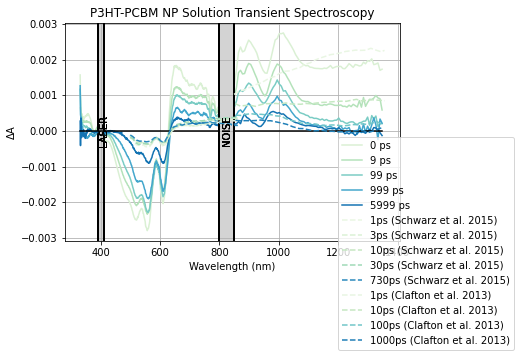

In [ ]:
# w/REF NP SOLUTION

dex = [1, 10, 100, 1000, 6000]
times = []
for i in range(len(dex)):
  times.append(find_nearest(Spec_data['P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)'].columns,dex[i], 'forward')+dex[i])
df = Spec_data['P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)']
df = df[df.index<800]
norm = abs(df[find_nearest(df.columns, 1, 'forward')+1]).max()

for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]])
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(dex[i]-0.6))+' ps', color=viridis((i+1)/(len(times)+1)))
times=[]
for i in range(len(dex)):
  times.append(find_nearest(Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)'].columns,dex[i], 'forward')+dex[i])
df_NIR = Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)']
df_NIR = df_NIR[df_NIR.index > 850]
df_NIR = df_NIR[df_NIR.index < 1350]

for i in range(len(times)):
  x = np.asarray(df_NIR.index)
  y = np.asarray(df_NIR[times[i]])*1.8

  plt.axvspan(800, 850, color='lightgray')
  plt.axvline(800, color='black')
  plt.axvline(850, color='black')
  plt.text(810,0, 'NOISE',rotation='vertical', va='center')
  plt.plot(x, y, color=viridis((i+1)/(len(times)+1)))

plt.plot(np.array(df.index), np.zeros(len(df.index), dtype=float, order='C'), color='black')
plt.plot(np.array(df_NIR.index), np.zeros(len(df_NIR.index), dtype=float, order='C'), color='black')

i=0
for name in sorted(Lit_data):
  maxes_to_normalize = []

  if ('Schwarz' in name) and ('P3HT-PCBM' in name):
    data = Lit_data[name]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    maxes_to_normalize.append(y.max())
    maxes_to_normalize.append(abs(y.min()))
    plt.plot(x, y, label=t + 'ps (Schwarz et al. 2015)', linestyle='--', color=viridis(np.log(np.int(t)+1)/np.log(6000)))
    i += 1

for name in sorted(Lit_data):
  maxes_to_normalize = []

  if ('Clafton' in name) and ('P3HT-PCBM' in name):
    data = Lit_data[name]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    maxes_to_normalize.append(y.max())
    maxes_to_normalize.append(abs(y.min()))
    plt.plot(x, y, label=t + 'ps (Clafton et al. 2013)', linestyle='--', color=viridis(np.log(np.int(t)+1)/np.log(6000)))
    i += 1


plt.title("P3HT-PCBM NP Solution Transient Spectroscopy")
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA')

plt.grid('both', 'both')
plt.legend(bbox_to_anchor=(0.8,0.5))
plt.show()

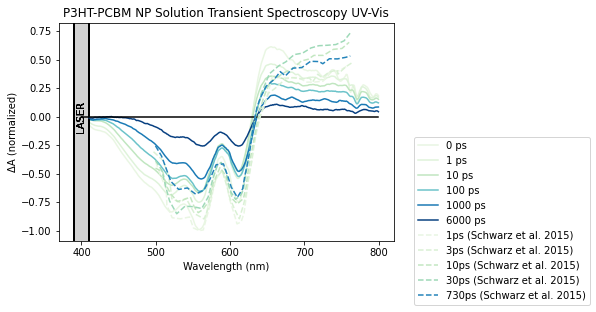

In [ ]:
# w/REF NP SOLUTION UV_VIS ONLY
viridis = cm.get_cmap('GnBu')

df = Spec_data['P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)']
df = df[df.index<800]
df = df[df.index>400]
norm = abs(df).max().max()
t0 = abs(df).max().idxmax(axis=1)

d1 = [0, 1,10, 100, 1000, 6000]
dex = d1+t0 
times = []
for i in range(len(dex)):
  times.append(find_nearest(Spec_data['P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)'].columns,dex[i], 'forward')+dex[i])
for i in range(len(times)):
  x = np.asarray(df.index)
  y = np.asarray(df[times[i]].rolling(3).mean())/norm
  y[(x>pump_wl-10) & (x<pump_wl+10)] =np.nan
  plt.axvspan(pump_wl-10, pump_wl+10, color='lightgray')
  plt.axvline(pump_wl-10, color='black')
  plt.axvline(pump_wl+10, color='black')
  plt.text(pump_wl-7,0, 'LASER',rotation='vertical', va='center')
  plt.plot(x, y,  label=str(int(d1[i]))+' ps', color=viridis(np.log(int(d1[i])+2)/np.log(5002)))


plt.plot(np.array(df.index), np.zeros(len(df.index), dtype=float, order='C'), color='black')

norm = 1
i=0
for name in sorted(Lit_data):
  maxes_to_normalize = []

  if ('Schwarz' in name) and ('P3HT-PCBM' in name):
    data = Lit_data[name]
    data = data[data.index<800]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    if int(t) == 1:
      norm = abs(y).max()
    plt.plot(x, y/norm, label=t + 'ps (Schwarz et al. 2015)', linestyle='--', color=viridis(np.log(np.int(t)+1)/np.log(5002)))
    i += 1



plt.title("P3HT-PCBM NP Solution Transient Spectroscopy UV-Vis")
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')

plt.legend(bbox_to_anchor=(1.6,0.5))
plt.show()

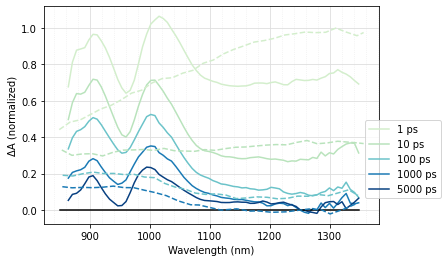

In [ ]:
#w/REF NIR COMPARISON NP SOLS
df_NIR = Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)']
df_NIR = df_NIR[df_NIR.index > 850]
df_NIR = df_NIR[df_NIR.index < 1350]

norm = abs(df_NIR[find_nearest(df_NIR.columns, 1, 'forward')+1].rolling(10).mean()).max()
t0 = abs(df_NIR).max().idxmax(axis=1)

d1 = [1,10, 100, 1000, 5000]
dex = d1
times = []
for i in range(len(dex)):
  times.append(find_nearest(Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)'].columns,dex[i], 'forward')+dex[i])


for i in range(len(times)):
  x = np.asarray(df_NIR.index)
  y = np.asarray(df_NIR[times[i]].rolling(3).mean())/norm
  plt.plot(x, y, label=str(d1[i])+' ps', color=viridis(np.log(np.int(d1[i])+5)/np.log(5005)))

plt.plot(np.array(df_NIR.index), np.zeros(len(df_NIR.index), dtype=float, order='C'), color='black')

norm = 1

for name in sorted(Lit_data):

  if ('Clafton' in name) and ('P3HT-PCBM' in name):
    data = Lit_data[name]
    x = np.asarray(data.index)
    y = np.asarray(data['ΔA'])
    for elem in name.split():
      if 'ps' in elem:
        t=elem.split(sep='ps')[0]
    if int(t) == 1:
      norm = abs(y).max()
    plt.plot(x, y/norm, linestyle='--', color=viridis(np.log(np.int(t)+5)/np.log(5005)))



plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
plt.tick_params(which='minor', bottom=False, left=False)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ΔA (normalized)')


plt.legend(bbox_to_anchor=(1.2,0.5))
plt.show()

     a1   t1
0  0.39  0.5


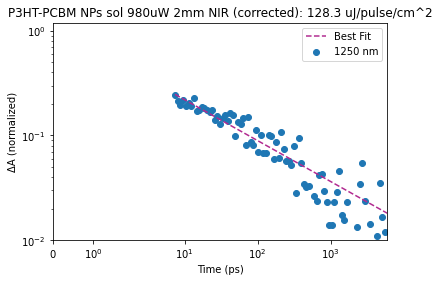

     a1   t1
0  0.57  0.3


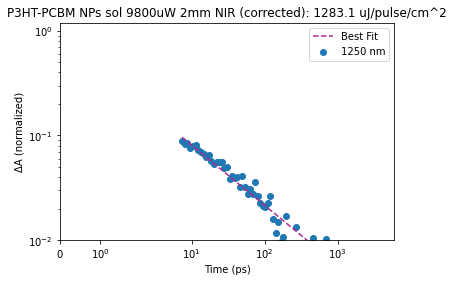

    a1   t1
0  0.3  0.4


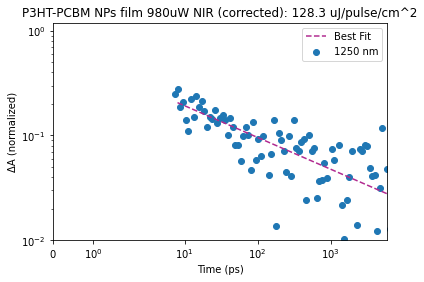

     a1   t1
0  0.45  0.3


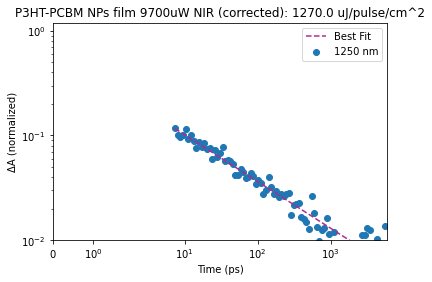

     a1   t1
0  0.47  0.3


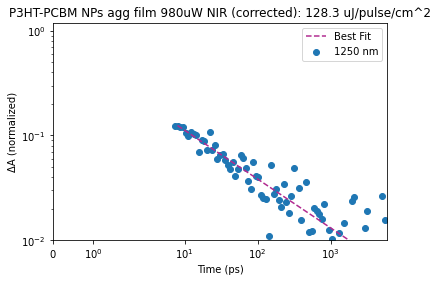

    a1   t1
0  0.4  0.2


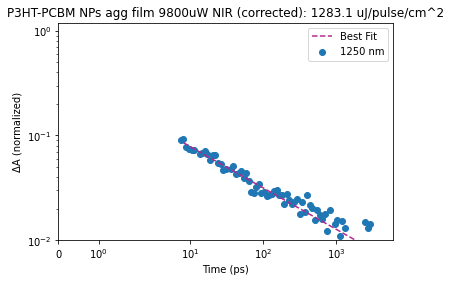

In [ ]:
#Kinetic algorithm
from scipy.optimize import curve_fit
from lmfit import Model, Parameter, Parameters, report_fit
def single_exp(x, a1, t1):
    return a1 * np.exp(-(x)/t1)

def double_exp(x, a1, a2, t1, t2):
  return a1*np.exp(-1*(x)/t1) + (a2)*np.exp(-1*(x)/t2)

def tri_exp(x, a1, t1, a2, t2, a3, t3):
  return a1*np.exp(-1*(x)/t1) + (a2)*np.exp(-1*(x)/t2) + (a3)*np.exp(-1*(x)/t3)

def power_law(x,a1,t1):
  return t1/(x**a1)

def k_fit(x, y, func, name=name):
  #find time of peak
  tmax = x[pd.DataFrame(y).idxmax()]
  x_fit = x[x>=tmax]
  y_fit = y[x>=tmax]
  model = Model(func, independent_vars=['x'])
  params = Parameters()
  params.add('a1', value=0.5, min=-1, max=1)
  params.add('t1', value=5, min=0, max=700000)


  result = model.fit(y_fit, params, x=x_fit)

  

  a1 = np.around(result.values['a1'], 2)

  t1 = np.around(result.values['t1'], 1)



  df = pd.DataFrame(data={'a1':a1, 't1':t1}, index=[0])
  print(df)

  plt.plot(x_fit, result.best_fit, '--', color=colormap(i/10), label='Best Fit')
  plt.legend(loc='best')
  return result


WLs_of_interest = [450, 590, 610, 660, 700, 750, 930, 1000, 1200,1250, 1300]
WL_UV = sorted(i for i in WLs_of_interest if i <= 800)
WL_NIR = sorted(i for i in WLs_of_interest if i > 800)

def find_nearest_dex(array, number, direction=None): 
    idx = -1
    if direction is None:
        ser = np.abs(array-number)
        idx = ser.get_loc(ser.min())
    elif direction == 'backward':
        _delta = number - array
        _delta_positive = _delta[_delta > 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc((_delta_positive.min()))
    elif direction == 'forward':
        _delta = array - number
        _delta_positive = _delta[_delta >= 0]
        if not _delta_positive.empty:
            idx = _delta.get_loc(_delta_positive.min())
    return idx
colormap = cm.get_cmap('plasma')
styles = [':', '--', '-.', (0, (3, 5, 1, 5)), (0, (1, 10)), (0, (1, 1)), (0, (3, 10, 1, 10, 1, 10)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (5, 5)),(0, (3, 1, 1, 1)),  (0, (1, 1))]
def k_chart(data, name, guess, func):

  dex = find_nearest_dex(data.index, guess)
  region = ''
  if guess > 800:
    region = 'NIR'
  elif guess <= 800:
    region = 'UV-Vis'
  #dd = data.iloc[dex-10:dex+10].mean()
  #data2 = dd[dd.index>1]
  #data3 = dd[(dd.index>1) & (dd.index<10)]
  #data4 = dd[(dd.index>400) & (dd.index<4500)]
  #update = pd.DataFrame(data4, columns = ['vals'])
  #slope = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[0]
  #intercept = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[1]
  #stderr = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[4]
  #update['estimate'] = 10**(slope*update.index+intercept)
  #+" -- Slope: "+str(np.around(slope, 6))+ " Std Err: "+str(np.around(stderr,8))

  
  
  i = WLs.index(guess)
  label = str(guess)+' nm'

  peak_to_norm =  data.iloc[dex-10:dex+10].mean().max()
  trough_to_norm = data.iloc[dex-10:dex+10].mean().min()
  norm = max(abs(peak_to_norm), abs(trough_to_norm))
  x = np.asarray(data.columns)

  y = abs(np.asarray(data.iloc[dex-10:dex+10].mean())/norm)
  tmax = x[pd.DataFrame(y).idxmax()]
  x=x-tmax
  y=y[x>7]
  x=x[x>7]
  plt.scatter(x,y, label=label)
  #plt.plot(np.asarray(update.index), np.asarray(update['estimate']), linewidth=0.8, color='black')

  k_fit(x, y, power_law, name)
  
  plt.ylabel('ΔA (normalized)')
  plt.yscale('log')
  plt.xscale('symlog')
  plt.ylim(0.01,1.2)
  plt.xlim(0,6000)
  plt.xlabel('Time (ps)')








def k_chart_bk(data, guess, label):
  f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

  # plot the same data on both axes
  ax.plot(x, y)
  ax2.plot(x, y)

  ax.set_xlim(0,7.5)
  ax2.set_xlim(40,42.5)

  # hide the spines between ax and ax2
  ax.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax.yaxis.tick_left()
  ax.tick_params(labelright='off')
  ax2.yaxis.tick_right()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

  d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
  kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
  ax.plot((1-d,1+d), (-d,+d), **kwargs)
  ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
  ax2.plot((-d,+d), (1-d,1+d), **kwargs)
  ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'


for name in Spec_data:
  if 'UV-Vis' in name:
    WLs = WL_UV
  elif 'NIR' in name:
    WLs = WL_NIR
    k_chart(Spec_data[name], name, 1250, tri_exp)
    title  = name + ': ' +str(np.around(fluence_translate(name), 1))+' uJ/pulse/cm^2'
    plt.title(title)
    plt.legend()
    plt.show()


**Note to self on Kinetics: Careful!** *Maybe use the raw data rather than the interpolated data. You don't want to change the curve via interpolation.*

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


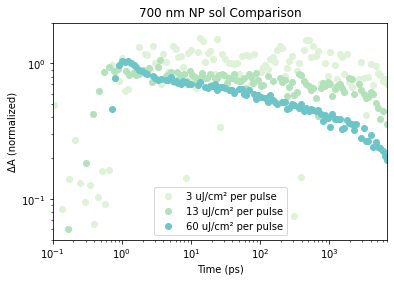

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


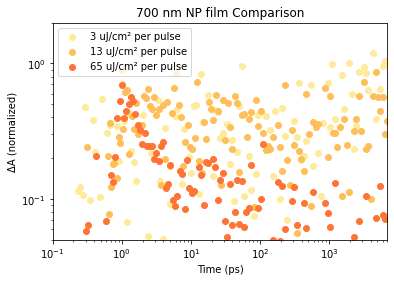

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


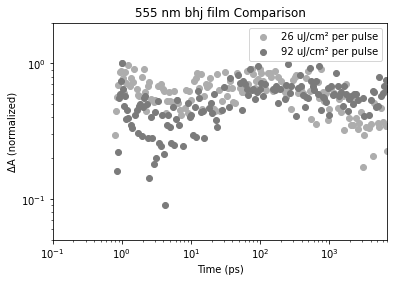

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


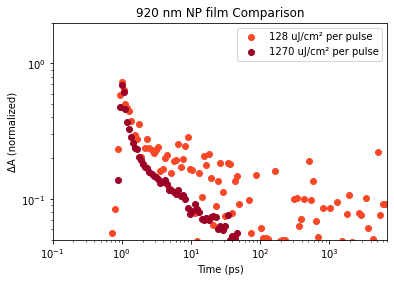

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


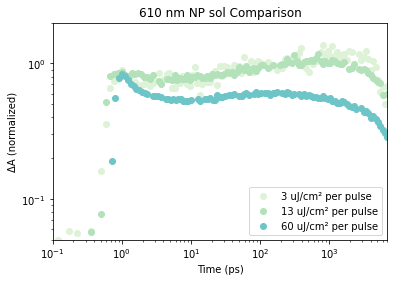

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


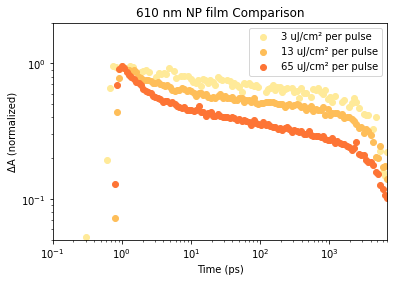

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


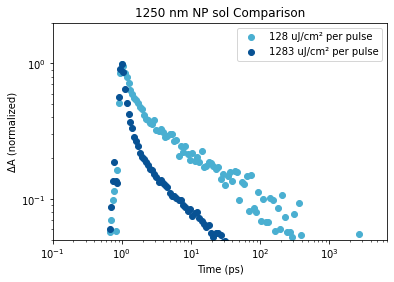

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


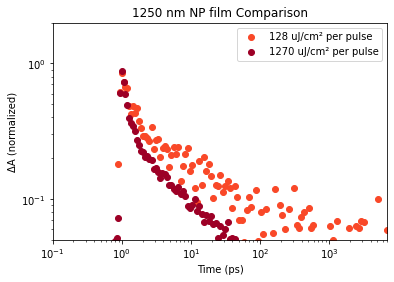

In [ ]:
#Kinetics 2: Compare same WL at different fluences
#Choose how to group
def color_map(name):
  if 'NP' in name:
    if ('film' in name) and ('agg' in name):
      colormap = cm.get_cmap('Inferno')
    elif 'film' in name:
      colormap = cm.get_cmap('YlOrRd')
    elif 'sol' in name:
      colormap = cm.get_cmap('GnBu') 
  elif 'bhj' in name:
    if 'PCBM' in name:
      colormap= cm.get_cmap('Greys')
    elif 'P3HT' in name:
      colormap= cm.get_cmap('YlGn')
  else:
    colormap = cm.get_cmap('viridis')
  return colormap


def fluence_compare(WL, *keywords):
  for dfs in Spec_data:
    if all(word in dfs for word in keywords) and ('agg' not in dfs):
      val = int(np.around(fluence_translate(dfs)))
      df = Spec_data[dfs]
      dex = find_nearest_dex(df.index, WL)
      #find normalization
      norm =  abs(df.iloc[dex][df.columns<1]).max()
      tmax =  abs(df.iloc[dex][df.columns<1]).idxmax(axis=1)
      t_adj = 1-tmax
      ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
      #define data, average 5 data points around target wavelength
      colormap = color_map(dfs)
      x = np.asarray(df.columns+t_adj)
      y = abs(np.asarray(df.iloc[dex-10:dex+10].mean())/norm)
      plt.scatter(x,y, c=colormap(np.log(val)/np.log(2000)), label=str(val)+' uJ/cm² per pulse')
  plt.ylabel('ΔA (normalized)')
  plt.yscale('log')
  plt.xscale('log')
  plt.xlim(0.1,7000)
  plt.ylim(0.05,2)
  plt.xlabel('Time (ps)')
  plt.title(str(WL)+' nm '+ keywords[1]+' '+ keywords[2]+' Comparison')
  plt.legend()



fluence_compare(700, 'UV-Vis', 'NP', 'sol')
plt.show()
fluence_compare(700, 'UV-Vis', 'NP', 'film')
plt.show()
fluence_compare(555, 'UV-Vis', 'bhj', 'film')
plt.show()
fluence_compare(920, 'NIR', 'NP', 'film')
plt.show()
fluence_compare(610, 'UV-Vis', 'NP', 'sol')
plt.show()
fluence_compare(610, 'UV-Vis', 'NP', 'film')
plt.show()
fluence_compare(1250, 'NIR', 'NP', 'sol')
plt.show()
fluence_compare(1250, 'NIR', 'NP', 'film')
plt.show()


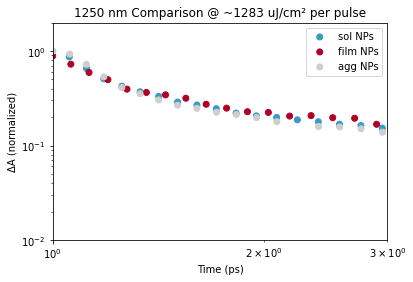

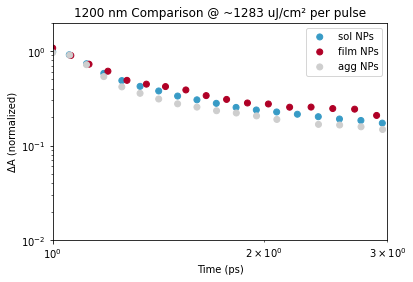

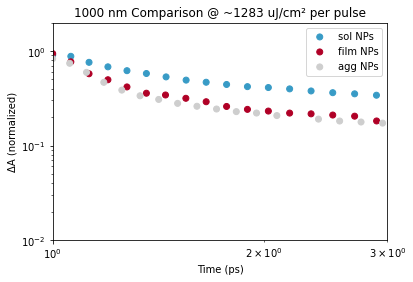

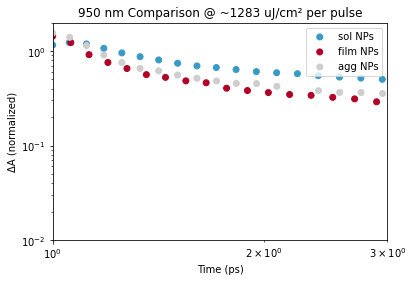

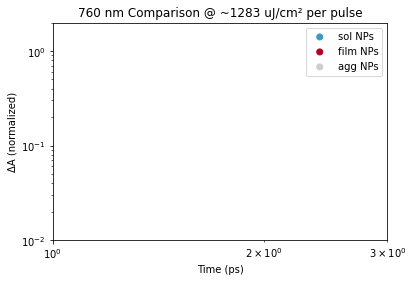

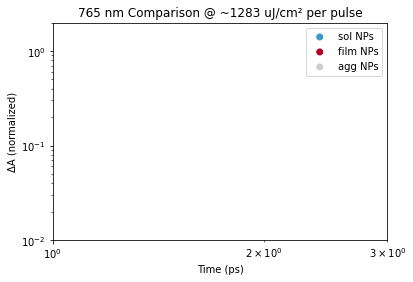

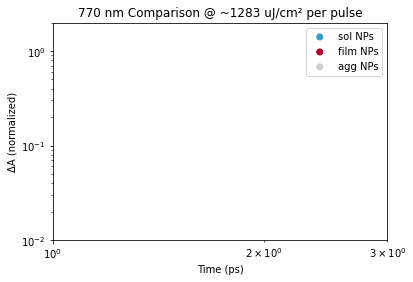

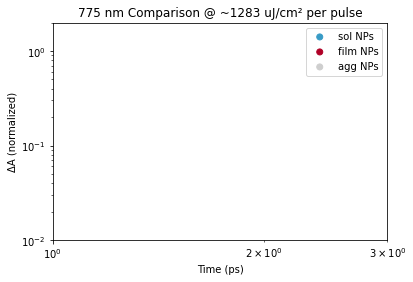

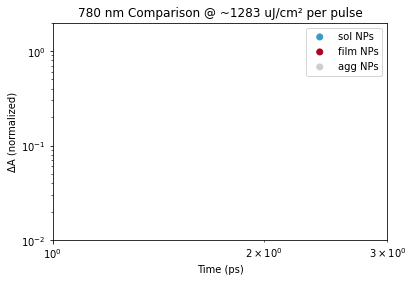

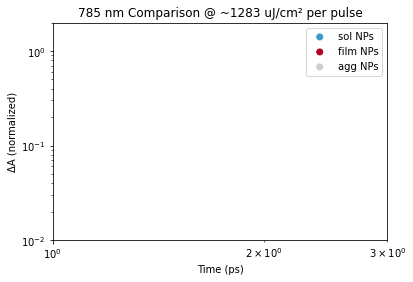

In [ ]:
#Compare different forms at same fluence
def k_compare_films(WL, name):
  val = np.around(fluence_translate(name), 1)
  for sets in Spec_data:
    test_val = np.around(fluence_translate(sets), 1)
    if (test_val > 0.8*val) and (test_val < 1.6*val):
      df = Spec_data[sets]
      dex = find_nearest_dex(df.index, WL)
      #find normalization
      norm =  abs(df.iloc[dex][df.columns<1]).max()
      tmax =  abs(df.iloc[dex][df.columns<1]).idxmax(axis=1)
      t_adj = 1-tmax
      ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
      #define data, average 5 data points around target wavelength
      x = np.asarray(df.columns+t_adj)
      y = abs(np.asarray(df.iloc[dex-10:dex+10].mean())/norm)
      l2 = sets.split(sep=' ')[1]
      l1 = sets.split(sep=' ')[2]
      cmap = plt.cm.GnBu
      r = [0.7]*len(y)
      if l1 == 'film':
        cmap=plt.cm.YlOrRd
        r = [0.9]*len(y)
      if (l1 == 'agg') or (l2 == 'bhj'):
        cmap=plt.cm.Greys
        r = [0.3]*len(y)
      if l2 == 'neat':
        l2 = 'P3HT neat'
        cmap=plt.cm.YlGn
        r = [0.8]*len(y)
      norm = plt.Normalize(vmin=0, vmax=1)
      plt.scatter(x,y, label=l1+' '+l2, c=cmap(norm(r)))
  plt.ylabel('ΔA (normalized)')
  plt.yscale('log')
  plt.xscale('log')
  plt.xlim(1,3)
  plt.ylim(0.01,2)
  plt.xlabel('Time (ps)')
  plt.title(str(WL)+' nm '+ 'Comparison @ ~'+str(int(np.around(fluence_translate(name))))+' uJ/cm² per pulse')
  plt.legend()
  plt.show()
Spec_data
n = 'P3HT-PCBM NPs film 9800uW NIR (corrected)'
k_compare_films(1250, n)
k_compare_films(1200, n)
k_compare_films(1000, n)
k_compare_films(950, n)
k_compare_films(760, n)
k_compare_films(765, n)
k_compare_films(770, n)
k_compare_films(775, n)
k_compare_films(780, n)
k_compare_films(785, n)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

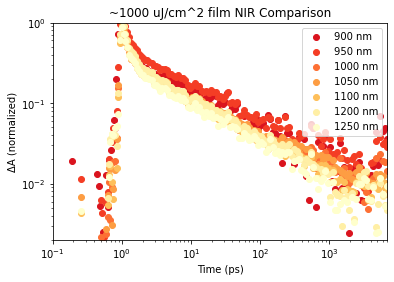

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

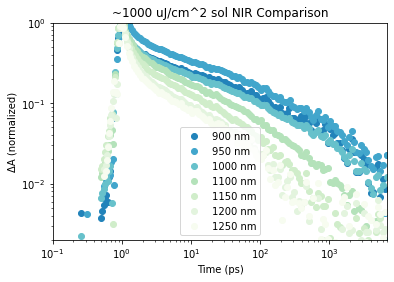

No handles with labels found to put in legend.


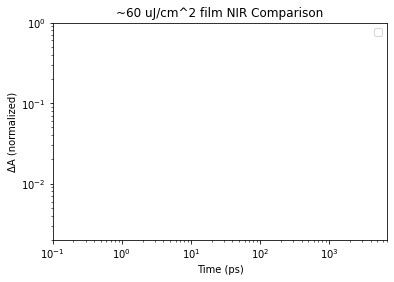

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


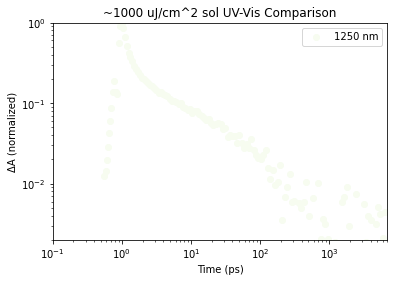

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


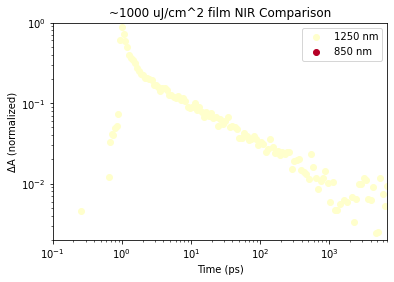

In [ ]:
#Compare multiple features
def k_compare_features(key1, key2, val, *WLs):
    for WL in WLs:
      if WL > 800:
        keywords = [key1, key2, 'NIR']
      else:
        keywords = [key1, key2, 'UV-Vis']
      for dfs in Spec_data:
        if all(word in dfs for word in keywords) and ('agg' not in dfs):
          test_val = int(np.around(fluence_translate(dfs)))
          if (test_val > 0.8*val) and (test_val < 1.6*val):
            df = Spec_data[dfs]
            dex = find_nearest_dex(df.index, WL)
            #find normalization
            norm =  abs(df.iloc[dex][df.columns<1]).max()
            tmax =  abs(df.iloc[dex][df.columns<1]).idxmax(axis=1)
            t_adj = 1-tmax
            ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
            #define data, average 5 data points around target wavelength
            colormap = color_map(dfs)
            x = np.asarray(df.columns+t_adj)
            y = abs(np.asarray(df.iloc[dex-10:dex+10].mean())/norm)
            plt.scatter(x,y, c=colormap((1251-WL)/451), label=str(WL)+' nm')
    plt.ylabel('ΔA (normalized)')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.1,7000)
    plt.ylim(0.002,1)
    plt.xlabel('Time (ps)')
    plt.title('~'+str(val)+' uJ/cm^2 '+ keywords[1]+' '+ keywords[2]+' Comparison')
    plt.legend()
    plt.show()
           
      

k_compare_features('NP', 'film',1000,900, 950, 1000, 1050, 1100,1200, 1250)
k_compare_features('NP', 'sol',1000, 900,950,1000,1100, 1150,1200, 1250)
k_compare_features('BHJ', 'film',60, 680, 980)
k_compare_features('NP', 'sol',1000, 1250, 670)
k_compare_features('NP', 'film',1000, 1250, 850)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


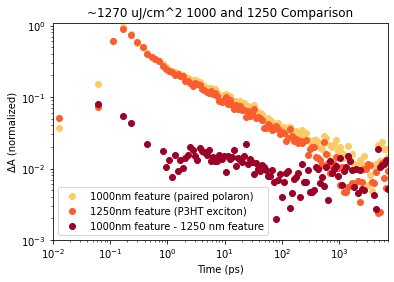

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


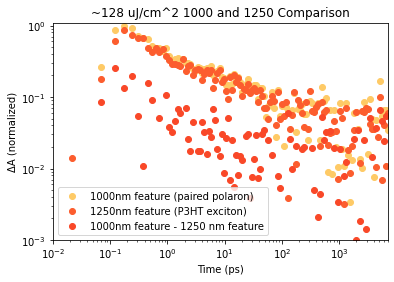

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


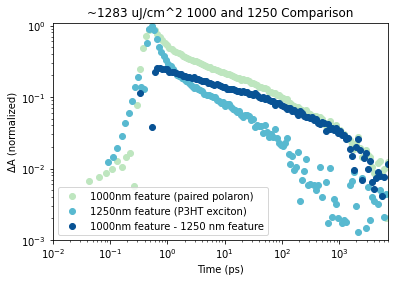

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


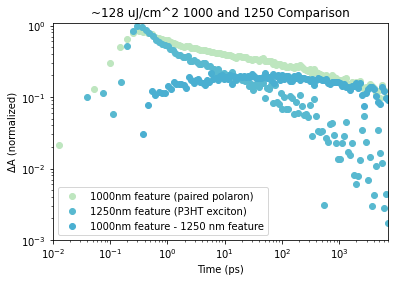

In [ ]:
def k_subtract_features(name, WL1, WL2, t_adj=0):
    df = Spec_data[name]
    dex1 = find_nearest_dex(df.index, WL1)
    dex2 = find_nearest_dex(df.index, WL2)
    #find normalization
    norm1 =  abs(df.iloc[dex1][df.columns<1]).max()
    tmax1 =  abs(df.iloc[dex1][df.columns<1]).idxmax(axis=1)
    t_adj1 = 1-tmax1
    ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
    #define data, average 5 data points around target wavelength
    colormap = color_map(name)
    x = np.asarray(df.columns)
    y1 = abs(np.asarray(df.iloc[dex1-10:dex1+10].mean())/norm1)
    plt.scatter(x,y1, c=colormap(np.log(10)/np.log(2300)), label=str(WL1)+'nm feature (paired polaron)')
    norm2 =  abs(df.iloc[dex2][df.columns<1]).max()
    tmax2 =  abs(df.iloc[dex2][df.columns<1]).idxmax(axis=1)
    t_adj2 = 1-tmax2-t_adj
    ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
    #define data, average 5 data points around target wavelength
    y2 = abs(np.asarray(df.iloc[dex2-10:dex2+10].mean())/norm2)
    plt.scatter(x-t_adj,y2, c=colormap(np.log(100)/np.log(2300)), label=str(WL2)+'nm feature (P3HT exciton)')
    normsub = abs(y1[x<2]-y2[x<2]).max()
    ysub = (y1-y2)/normsub
    plt.scatter(x,(y1-y2), c=colormap(np.log(fluence_translate(name))/np.log(2000)), label=str(WL1)+'nm feature - '+str(WL2)+ ' nm feature')
    plt.ylabel('ΔA (normalized)')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.01,7000)
    plt.ylim(0.001,1.1)
    plt.xlabel('Time (ps)')
    plt.title('~'+str(int(fluence_translate(name)))+' uJ/cm^2 '+ str(WL1)+' and '+ str(WL2)+' Comparison')

    plt.legend()

Spec_data['P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)']
name = 'P3HT-PCBM NPs film 9700uW NIR (corrected)'
k_subtract_features(name, 1000, 1250)
plt.show()
k_subtract_features('P3HT-PCBM NPs film 980uW NIR (corrected)', 1000, 1250)
plt.show()
k_subtract_features('P3HT-PCBM NPs sol 9800uW 2mm NIR (corrected)', 1000, 1250,-0.05)
plt.show()
k_subtract_features('P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)', 1000, 1250, -0.1)
plt.show()



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


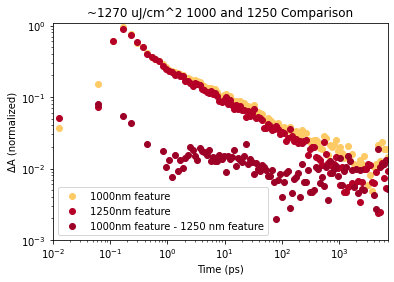

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


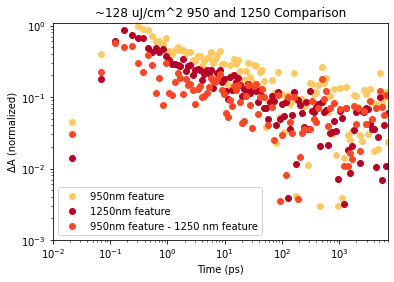

In [ ]:
name = 'P3HT-PCBM NPs film 9700uW NIR (corrected)'
k_subtract_features(name, 1000, 1250)
plt.show()
k_subtract_features('P3HT-PCBM NPs film 980uW NIR (corrected)', 1000, 1250)
plt.show()

In [ ]:
def k_free_compare(*names, **WLs):
  for i in range(len(names)):
    name = names[i]
    df = Spec_data[name]
    dex = find_nearest_dex(df.index, WLs[i])
    norm =  abs(df.iloc[dex][df.columns<1]).max()
    tmax =  abs(df.iloc[dex][df.columns<1]).idxmax(axis=1)
    t_adj = 1-tmax
    ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
    #define data, average 5 data points around target wavelength
    x = np.asarray(df.columns+t_adj)
    y = abs(np.asarray(df.iloc[dex-10:dex+10].mean())/norm)


    cmap = plt.cm.GnBu
    r = [0.7]*len(y)
    if 'film' in name:
      cmap=plt.cm.YlOrRd
      r = [0.9]*len(y)
      if ('agg') in name:
        cmap=plt.cm.Inferno
        r = [0.3]*len(y)
      if ('bhj') in name:
        cmap=plt.cm.greys
        r = [0.3]*len(y)
      if 'neat' in name:
        cmap=plt.cm.YlGn
        r = [0.8]*len(y)
    norm = plt.Normalize(vmin=0, vmax=1)
    plt.scatter(x,y, label=name + ' @ '+str(WLs[i])+ 'nm', c=cmap(norm(r)))
  plt.ylabel('ΔA (normalized)')
  plt.yscale('log')
  plt.xscale('log')
  plt.ylim(0.001,2)
  plt.xlabel('Time (ps)')
  plt.legend()
  plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


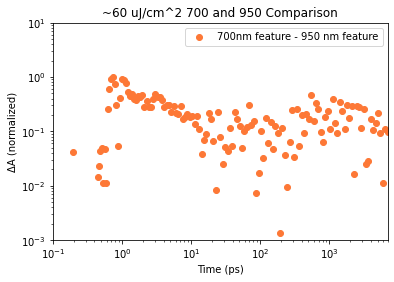

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


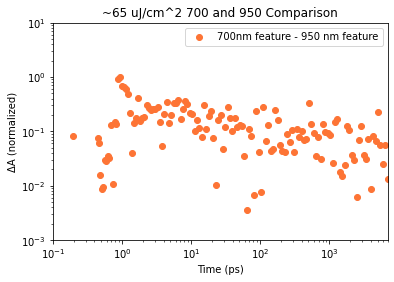

In [ ]:
def k_subtract_2features(name1, name2, WL1, WL2):
    df1 = Spec_data[name1]
    df2 = Spec_data[name2]
    dex1 = find_nearest_dex(df1.index, WL1)
    dex2 = find_nearest_dex(df2.index, WL2)
    #find normalization
    norm1 =  abs(df1.iloc[dex1][df1.columns<1]).max()
    tmax1 =  abs(df1.iloc[dex1][df1.columns<1]).idxmax(axis=1)
    t_adj1 = 1-tmax1
    ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
    #define data, average 5 data points around target wavelength
    colormap = color_map(name)
    x = np.asarray(df1.columns+t_adj1)
    y1 = abs(np.asarray(df1.iloc[dex1-10:dex1+10].mean())/norm1)
    #to match size, interpolate y1 data with x2 axis
    f = interp1d(x, y1, 'cubic', fill_value='extrapolate')
    norm2 =  abs(df2.iloc[dex2][df2.columns<1]).max()
    tmax2 =  abs(df2.iloc[dex2][df2.columns<1]).idxmax(axis=1)
    t_adj2 = 1-tmax2
    ##NOTE TO SELF: MAY WANT TO CONSIDER STANDARDIZING TMAX
    #define data, average 5 data points around target wavelength
    x = np.asarray(df2.columns+t_adj2)
    y1_new = f(x)
    y2 = abs(np.asarray(df2.iloc[dex2-10:dex2+10].mean())/norm2)
    normsub = abs(y1_new[x<2]-y2[x<2]).max()
    ysub = abs((y1_new-y2)/normsub)
    plt.scatter(x,ysub, c=colormap(np.log(fluence_translate(name1))/np.log(2000)), label=str(WL1)+'nm feature - '+str(WL2)+ ' nm feature')
    plt.ylabel('ΔA (normalized)')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.1,7000)
    plt.ylim(0.001,10)
    plt.xlabel('Time (ps)')
    plt.title('~'+str(int(fluence_translate(name1)))+' uJ/cm^2 '+ str(WL1)+' and '+ str(WL2)+' Comparison')

    plt.legend()
    plt.show()


k_subtract_2features('P3HT-PCBM NPs solution 461uW 2mm  UV-Vis (corrected)','P3HT-PCBM NPs sol 980uW 2mm NIR (corrected)', 700, 950)
k_subtract_2features('P3HT-PCBM NPs film 500uW UV-Vis (corrected)','P3HT-PCBM NPs film 980uW NIR (corrected)', 700, 950)

In [ ]:





          
    



#Kinetics 3: Create a function which subtracts normalized kinetics at one WL from another and plot it (e.g. remove P3HT exciton)
def averaged_kinetics_norm(data, guess):
  dex = find_nearest_dex(data.index, guess)
  peak_to_norm =  data.iloc[dex-10:dex+10].mean().max()
  trough_to_norm = data.iloc[dex-10:dex+10].mean().min()
  norm = max(abs(peak_to_norm), abs(trough_to_norm))
  if abs(trough_to_norm) > abs(peak_to_norm):
    norm = -1*norm
  x = np.asarray(data.columns)
  y = np.asarray(data.iloc[dex-10:dex+10].mean())/norm
  return x, y

def isolate_polaron(data, exc_wl, pol_wl):
  x_exc, y_exc = averaged_kinetics_norm(data, exc_wl)
  x_pol, y_pol = averaged_kinetics_norm(data, pol_wl)
  f = interp1d(x_pol, y_pol)
  y_pol_approx = f(x_exc)
  pol_sig = y_pol_approx - y_exc
  pol_sig_norm = pol_sig/np.nanmax(pol_sig)
  plt.plot(x_exc, y_exc, label = 'Exciton signature: ' + str(exc_wl), linestyle='-')
  plt.plot(x_exc, pol_sig_norm, label='Inferred polaron: ' +str(pol_wl), linestyle=':')
  plt.plot(x_pol, y_pol, label='Raw signature: '+str(pol_wl), linestyle='-.')
  plt.xscale('log')
  plt.xlim(0.01,6500)
  plt.legend()
  plt.show()

for name in Spec_data:
  if 'NIR' in name:
    data = Spec_data[name]
    isolate_polaron(data, 1200, 1000)


#Kinetics 4: Fitting models!


def kinetic_fit(dataset, name, func, WL, *args):
  x = np.asarray(data.columns)
  y = abs(np.asarray(data.iloc[dex-10:dex+10].mean())/norm)
  model = Model(func, independent_vars=['x'])
  params = model.make_params(a=1, b=30, c=0)
  result = model.fit(ydata, params, x=xdata)
  a = result.values['a']
  b = result.values['b']
  c = result.values['c']
  if typ=='MAPI':
    col='blue'
    sty = ':'
  elif typ=='TC':
    col='orange'
    sty = '--'
  print(str(a)+' '+str(b)+' '+str(c))
  plt.scatter(xdata, ydata, s=20, label=typ)
  plt.plot(xdata, result.best_fit, sty, label=str(np.around(a,4))+'exp{-x/'+str(np.around(b,1))+'} + '+str(np.around(c,4)), color=col)
  plt.legend(loc='best')
  return result

In [ ]:
hc = 1239.842
frame = pd.DataFrame(columns=['Solvent', 'Energy(eV)', 'Slope', 'Std Err', 'Material'])
def table_add(data, guess, name, scale):
  dex = find_nearest_dex(data.index, guess)
  dd = data.iloc[dex-10:dex+10].mean()
  if 'Acetone' not in fn.get(name):
    solvent = fn.get(name).split(' ')[0]
    material = fn.get(name).split(' ')[1]
  elif 'Acetone' in fn.get(name):
    solvent = fn.get(name).split(' ')[0]
    material = fn.get(name).split(' ')[2]
  if scale == 0:
    data4 = dd[(dd.index>1) & (dd.index<10)]
  if scale == 1:
    data4 = dd[(dd.index>10) & (dd.index<101)]
  if scale == 2:
    data4 = dd[(dd.index>400) & (dd.index<4500)]
  slope = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[0]
  stderr = linregress(np.asarray(data4.index), np.asarray(np.log10(abs(data4))))[4]
  return {'Solvent':solvent,'Energy(eV)':np.around(guess,2), 'Slope':slope, 'Std Err':stderr, 'Material':material}
for name in sorted(Spec_data):
  if int(name[0:2])%4 == 1:
    Es = switch(name, [hc/865 ,hc/934, hc/1150,hc/632, hc/585, hc/425,hc/1255 ,hc/898, hc/968, 1.77, 1.92], [hc/885 ,hc/934, hc/1150,1.96, 2.12, 2.92],[hc/1255 ,hc/898, hc/968, 1.77, 1.92])
    for value in Es:
      for name2 in sorted(Spec_data):
        if switch(name, 1, 2, 3) == switch(name2, 1, 2, 3):
          
          if value>=1.77 and "UvVis" in name2:
            dic = {'01':'01 CB blend ','02':'02 CF blend ','03':'03 OX blend ','04':'04 CSA blend','05':'05 CB PBDBT ','06':'06 CF PBDBT ','07':'07 OX PBDBT ','08':'08 CSA PBDBT','09':'09 CB ITIC 1','10':'10 CF ITIC 1','11':'11 OX ITIC 1','12':'12 CSA ITIC '}
            lab = dic.get(name2[0:2])
            frame = frame.append(table_add(abs(Spec_data[name2]), value, lab, 2), ignore_index=True)
          elif value<1.77 and 'UvVis' not in name2:
            frame = frame.append(table_add(abs(Spec_data[name2]), value, name2[0:12], 2), ignore_index=True)
frame = frame.set_index('Solvent')
frame = frame.sort_values(by=['Energy(eV)', 'Solvent'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)

Plotting 3d

In [ ]:
#code from https://blog.finxter.com/matplotlib-3d-plot-advanced/
#https://stackoverflow.com/questions/36589521/how-to-surface-plot-3d-plot-from-dataframe
for name in merged_data:
  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)
  # Create x and y 1D arrays
  a = np.asarray(merged_data[name].index)
  b = np.asarray(merged_data[name].columns)
  X,Y = np.meshgrid(a, b)
  # Create X and Y 2D arrays
  Z = merged_data[name].T
  # Plot using Axes notation
  surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=1, antialiased=False)
  # Set axes lables
  ax.set(xlabel='Wavelength(nm)', ylabel='time (ps)', zlabel='dA')
  ax.view_init(elev=20, azim=100)
  ax.set_zlim(-.04, .01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.title.set_text(name + ' Transient Spectroscopy')
  plt.show()


Kinetics?